## PREDICTING CARDIOVASCULAR DISEASE USING PRINCIPAL COMPONENT ANALYSIS (PCA) AND XGBOOST CLASSIFICATION IN AWS SAGEMAKER


Aim of the problem is to detect the presence or absence of cardiovascular disease in person based on the given features.
Features available are:


- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Note that:
- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.

Data Source:https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

#### IMPORT LIBRARIES AND DATASETS

In [ ]:
# !pip install scikit-learn==1.5.1

In [ ]:
# import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# read the csv file 
cardio_df = pd.read_csv("cardio_train.csv", sep=";")
cardio_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


EXPLORATORY DATA ANALYSIS

In [ ]:
# Drop id

cardio_df = cardio_df.drop(columns = 'id')

In [ ]:
# since the age is given in days, we convert it into years

cardio_df['age'] = round(cardio_df['age']/365,1)

In [ ]:
cardio_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.4,2,168,62.0,110,80,1,1,0,0,1,0
1,55.4,1,156,85.0,140,90,3,1,0,0,1,1
2,51.7,1,165,64.0,130,70,3,1,0,0,0,1
3,48.3,2,169,82.0,150,100,1,1,0,0,1,1
4,47.9,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
# checking the null values
cardio_df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [ ]:
# Checking the dataframe information

cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.4 MB


In [ ]:
# Statistical summary of the dataframe
cardio_df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.339486,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.759534,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,29.600000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.400000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.400000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000



- Obtain the features of the individuals who are older than 64.8 years old 

In [ ]:
older_df = cardio_df[cardio_df['age'] > 64.8]
older_df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
18062,64.9,1,140,48.0,170,100,2,1,0,0,1,1
20931,64.9,1,165,63.0,150,90,2,1,0,0,1,1
36603,64.9,2,163,55.0,120,80,3,1,1,0,1,1
37677,64.9,2,165,64.0,120,80,1,1,0,0,1,1
40099,64.9,1,165,74.0,120,80,1,1,0,0,1,0
50714,64.9,2,167,68.0,120,80,2,2,0,0,0,1
55533,64.9,1,160,60.0,120,80,1,1,0,0,1,1
57191,65.0,2,175,75.0,120,80,1,1,0,0,1,1
57853,64.9,1,165,65.0,130,80,1,1,0,0,1,1
59784,64.9,2,170,68.0,110,80,2,2,0,0,0,1


#### VISUALIZE DATASET


- plot the histogram for all features (use 20 bins) 
- plot the correlation matrix and indicate if there exists any correlations between features

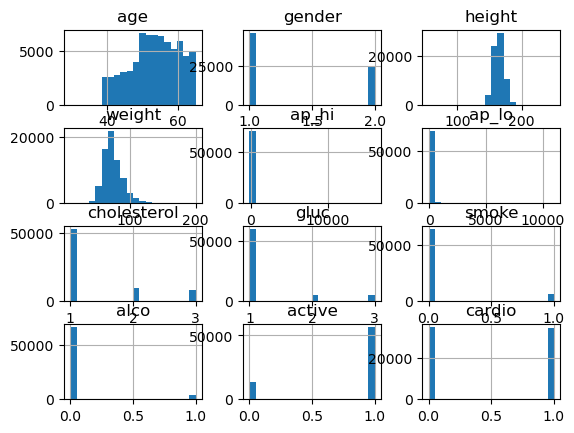

In [ ]:
cardio_df.hist(bins=20)
plt.show()

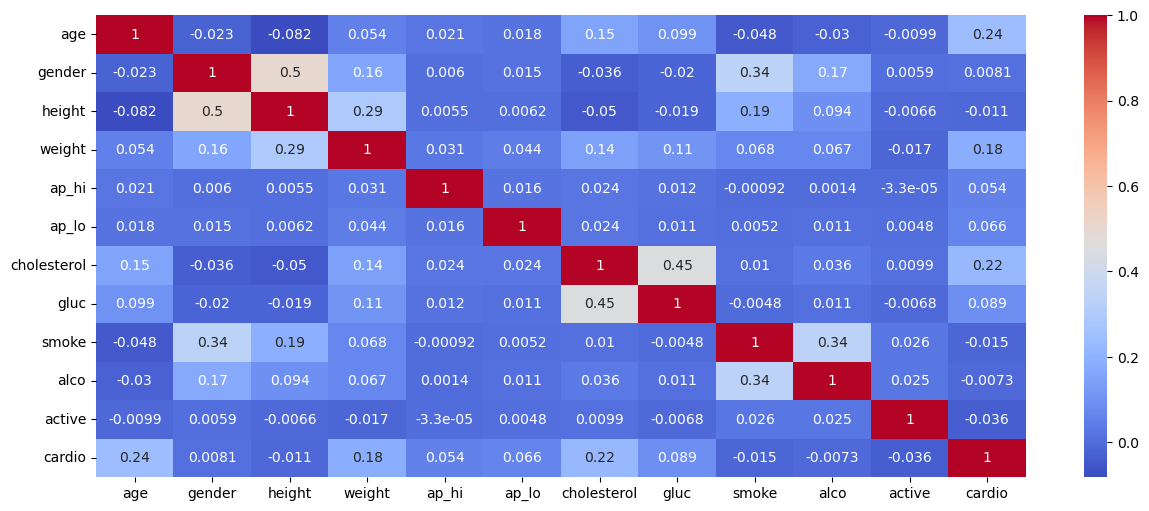

In [ ]:
# Calculate the correlation matrix
fig, ax = plt.subplots(figsize=(15, 6))
corr_matrix = cardio_df.corr()

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

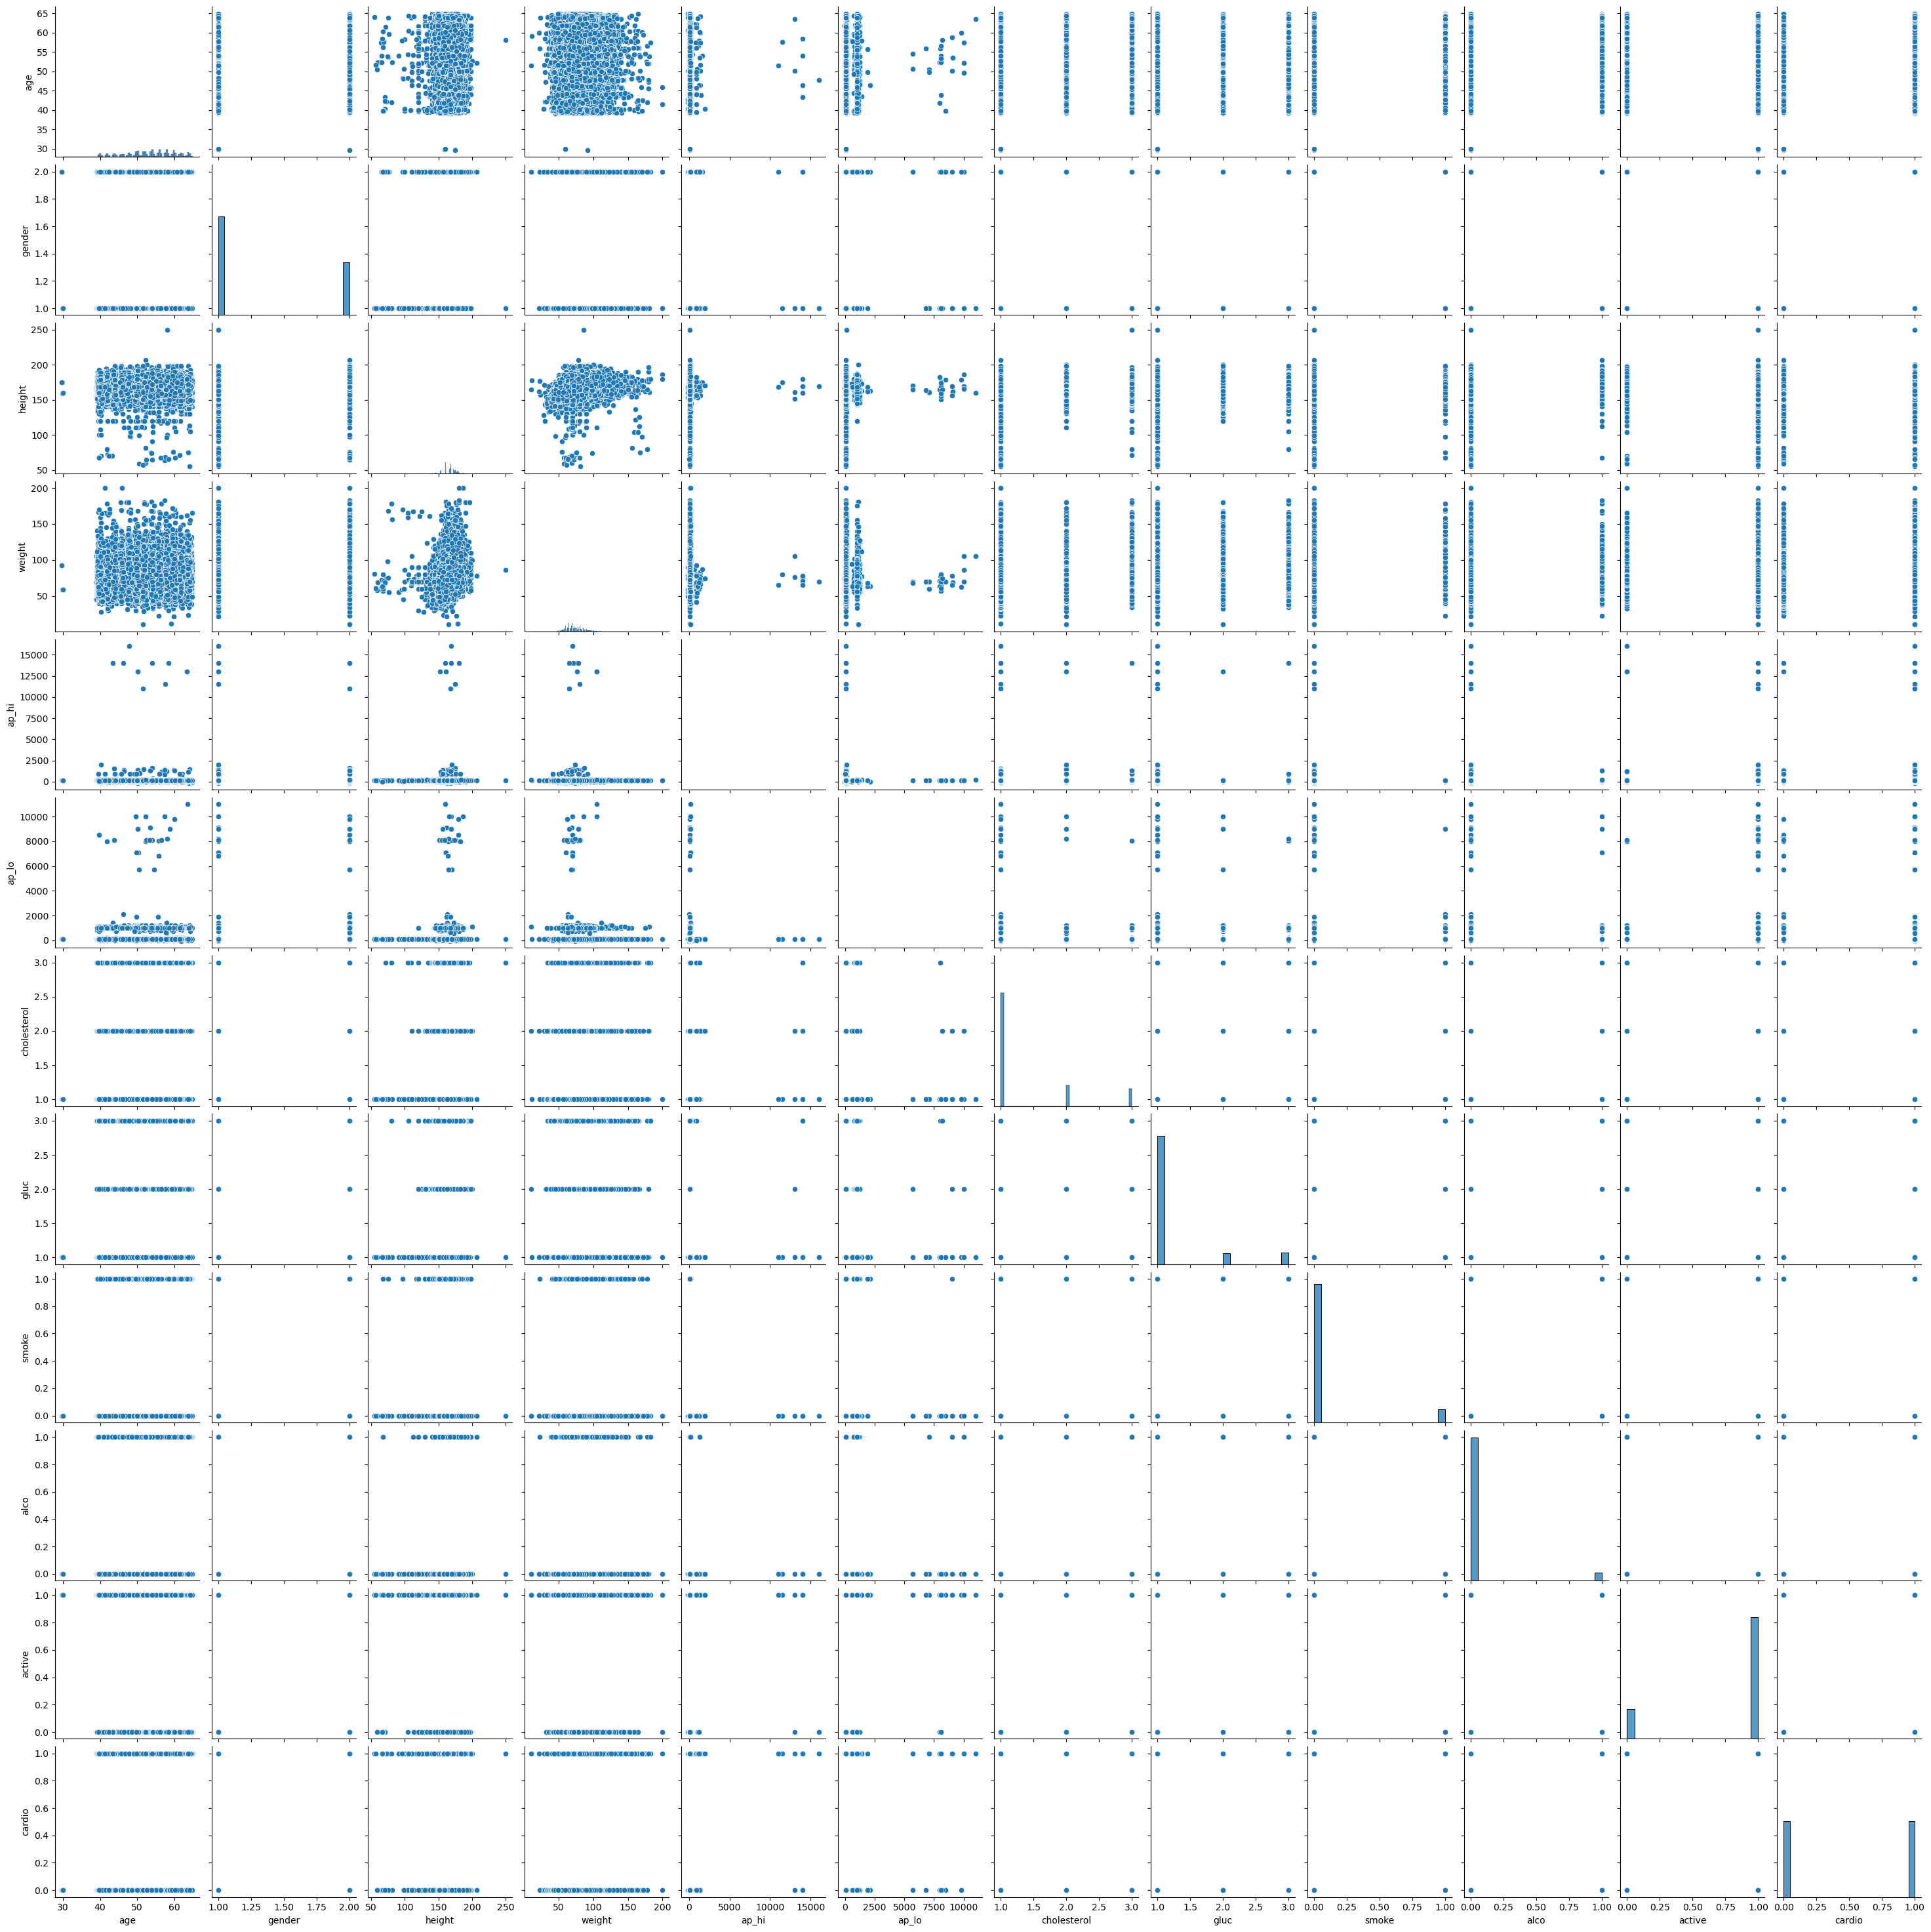

In [ ]:
sns.pairplot(cardio_df)

#### CREATE TRAINING AND TESTING DATASETS

In [ ]:
# split the dataframe into target and features

df_target = cardio_df['cardio']
df_final = cardio_df.drop(columns =['cardio'])

In [ ]:
cardio_df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [ ]:
type(df_final), df_final.shape

(pandas.core.frame.DataFrame, (70000, 11))

In [ ]:
df_target.shape

(70000,)

In [ ]:
#spliting the data in to test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_final, df_target, test_size = 0.2)

In [ ]:
X_train.shape

(56000, 11)

In [ ]:
y_train.shape

(56000,)

In [ ]:
X_test.shape

(14000, 11)

In [ ]:
X_test.shape

(14000, 11)

#### RAIN AND TEST XGBOOST MODEL IN LOCAL MODE (NOTE THAT SAGEMAKER BUILT-IN ALGORITHMS ARE NOT USED HERE)

In [ ]:
# install xgboost

!pip install xgboost

In [ ]:
# use xgboost model in local mode

# note that we have not performed any normalization or scaling since XGBoost is not sensitive to this.
# XGboost is a type of ensemble algorithms and works by selecting thresholds or cut points on features to split a node. 
# It doesn't really matter if the features are scaled or not.

from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.01, n_estimators=500, max_depth=20, objective='binary:logistic')
# model = XGBClassifier()

model.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# make predictions on test data

predict = model.predict(X_test)

In [ ]:
predict

array([0, 0, 0, ..., 0, 1, 1])

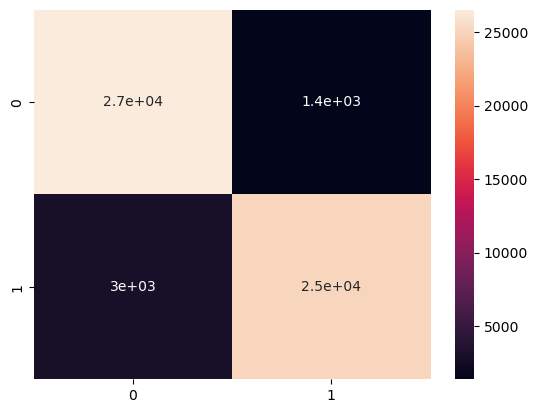

In [ ]:
# Assess trained model performance on training dataset
predict_train = model.predict(X_train)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, predict_train)
plt.figure()
sns.heatmap(cm, annot=True)
plt.show()

In [ ]:
# print metrics for training dataset

from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision = {}".format(precision_score(y_train, predict_train)))
print("Recall = {}".format(recall_score(y_train, predict_train)))
print("Accuracy = {}".format(accuracy_score(y_train, predict_train)))

Precision = 0.9477600664803203
Recall = 0.8932678272633415
Accuracy = 0.9217678571428571


In [ ]:
# print metrics for testing dataset

print("Precision = {}".format(precision_score(y_test, predict)))
print("Recall = {}".format(recall_score(y_test, predict)))
print("Accuracy = {}".format(accuracy_score(y_test, predict)))

Precision = 0.7257651138248153
Recall = 0.6986937590711175
Accuracy = 0.7217857142857143


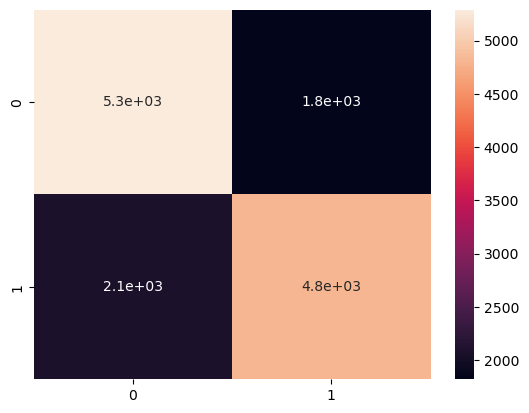

In [ ]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict)
plt.figure()
sns.heatmap(cm, annot=True)
plt.show()


 - Retrain the XGBoost algorithm with large number of estimators (n_estimators = 500) and more depth (max_depth = 20)
 - Comment on the accuracy for both the training and testing data 


- Attempt to tune the XGBoost classifier using gridsearch, start with the param_grid listed below
- Check out these great resources: https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e


In [ ]:
param_grid = {
        'gamma': [0.5, 1, 5],   # regularization parameter 
        'subsample': [0.6, 0.8, 1.0], # % of rows taken to build each tree
        'colsample_bytree': [0.6, 0.8, 1.0], # number of columns used by each tree
        'max_depth': [3, 4, 5] # depth of each tree
        }

xgb_model = XGBClassifier(learning_rate=0.01, n_estimators=100, objective='binary:logistic')

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(xgb_model, param_grid, refit = True, verbose = 4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.6;, score=0.727 total time=   0.4s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.6;, score=0.728 total time=   0.5s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.6;, score=0.725 total time=   0.4s
[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.6;, score=0.726 total time=   0.4s
[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.6;, score=0.726 total time=   0.4s
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.8;, score=0.727 total time=   0.4s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.8;, score=0.728 total time=   0.4s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.8;, score=0.725 total time=   0.4s
[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, subsample=0.8;, score=0.727 tot

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 5], 'max_depth': [3, 4, 5],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=4)

In [ ]:
y_predict_optim = grid.predict(X_test)

In [ ]:
y_predict_optim

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
# print metrics for testing dataset

print("Precision = {}".format(precision_score(y_test, y_predict_optim)))
print("Recall = {}".format(recall_score(y_test, y_predict_optim)))
print("Accuracy = {}".format(accuracy_score(y_test, y_predict_optim)))

Precision = 0.768368010403121
Recall = 0.686066763425254
Accuracy = 0.7437142857142857


#### PERFORM DIMENSIONALITY REDUCTION USING PCA (USING SAGEMAKER)

In [ ]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developer to write software that makes use of services like Amazon S3 and Amazon EC2

import sagemaker
import boto3
from sagemaker import Session

# Let's create a Sagemaker session
sagemaker_session = sagemaker.Session()

# Define some s3 storage paths
bucket = 'woodzee-data-science-projects' 
prefix = 'PCA-Model'
key =  'PCA-Model'

#Let's get the execution role for the notebook instance. 
# This is the IAM role that you created when you created your notebook instance. You pass the role to the training job.
# Note that AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results, called model artifacts, from the S3 bucket and writing training results to Amazon S3). 

role = sagemaker.get_execution_role()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/05/25 21:58:34] INFO     Found credentials from IAM Role:                                   ]8;id=349042;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=871177;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


                    INFO     Found credentials from IAM Role:                                   ]8;id=788548;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=759087;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[02/05/25 21:58:35] INFO     Found credentials from IAM Role:                                   ]8;id=129401;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=343311;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [ ]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker PCA

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
df_matrix = df_final.to_numpy() # convert the dataframe into 2-dimensional array
smac.write_numpy_to_dense_tensor(buf, df_matrix)
buf.seek(0)

# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 

0

In [ ]:
import os

# Code to upload RecordIO data to S3
 
# Key refers to the name of the file 

#following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)

print('uploaded training data location: {}'.format(s3_train_data))

                    INFO     Found credentials from IAM Role:                                   ]8;id=674999;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=275736;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

uploaded training data location: s3://woodzee-data-science-projects/PCA-Model/train/PCA-Model


In [ ]:
# create output placeholder in S3 bucket to store the PCA output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://woodzee-data-science-projects/PCA-Model/output


In [ ]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the pca container image
# Note that all  models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session


from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'pca')

[02/05/25 21:58:36] WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=894513;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=857629;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=101410;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=961661;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=813176;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=735646;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

In [ ]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training

pca = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session)

# We can tune parameters like the number of features that we are passing in, mode of algorithm, mini batch size and number of pca components


pca.set_hyperparameters(feature_dim=11,
                        num_components=6,
                        subtract_mean=False,
                        algorithm_mode='regular',
                        mini_batch_size=100)


# Pass in the training data from S3 to train the pca model

pca.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

                    WARNING  train_instance_count has been renamed in sagemaker>=2.              ]8;id=4073;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=829749;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_instance_type has been renamed in sagemaker>=2.               ]8;id=480666;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=607484;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=956233;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=865756;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: pca-2025-02-05-21-58-36-235           ]8;id=50387;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=725967;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-02-05 21:58:37 Starting - Starting the training job...
..25-02-05 21:58:52 Starting - Preparing the instances for training.
..25-02-05 21:59:17 Downloading - Downloading input data.
.....02-05 21:59:42 Downloading - Downloading the training image.
.Docker entrypoint called with argument(s): trainpleted. Training in progress..
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[02/05/2025 22:01:19 INFO 140533586302784] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[02/05/2025 22:01:19 INFO 140533586302784] Merging with provided configuration from /op


2021-03-25 18:52:06 Completed - Training job completed
Training seconds: 50
Billable seconds: 50


MINI CHALLENGE:
 - Retrain the model with the following number of components 5, 4, and 7 

#### DEPLOY THE TRAINED PCA MODEL 

In [ ]:
# Deploy the model to perform inference 

pca_reduction = pca.deploy(initial_instance_count = 1,
                        instance_type = 'ml.m4.xlarge',
                        endpoint_name='pca-model')

[02/05/25 22:01:53] INFO     Creating model with name: pca-2025-02-05-22-01-53-762                  ]8;id=97199;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=7293;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[02/05/25 22:01:54] INFO     Creating endpoint-config with name pca-model                           ]8;id=996521;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=986413;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name pca-model                                  ]8;id=289160;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=167975;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

----------!

In [ ]:
'''
Content type over-rides the data that will be passed to the deployed model, since the deployed model expects data
in text/csv format, we specify this as content -type.

Serializer accepts a single argument, the input data, and returns a sequence of bytes in the specified content
type

Reference: https://sagemaker.readthedocs.io/en/stable/predictors.html
'''

from sagemaker.serializers import CSVSerializer, JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

pca_reduction.serializer = CSVSerializer(content_type='text/csv')
pca_reduction.deserializer = JSONDeserializer(accept='application/json')

In [ ]:
# make prediction on the test data

result = pca_reduction.predict(np.array(df_final))

In [ ]:
result['projections'][0:11] # results are in Json format, show 10 sample projections

[{'projection': [-0.28927430510520935,
   3.9868838787078857,
   -12.550577163696289,
   64.24236297607422,
   36.821571350097656,
   -217.84942626953125]},
 {'projection': [1.0961072444915771,
   -4.759547233581543,
   12.366926193237305,
   44.577857971191406,
   45.66518020629883,
   -241.0219268798828]},
 {'projection': [1.335912823677063,
   1.764920949935913,
   -9.740692138671875,
   53.43294906616211,
   55.75614929199219,
   -223.02288818359375]},
 {'projection': [-0.41676995158195496,
   6.132817268371582,
   5.679876327514648,
   43.04627990722656,
   45.01065444946289,
   -257.24615478515625]},
 {'projection': [-0.15034562349319458,
   2.650604009628296,
   -13.213241577148438,
   63.61661148071289,
   44.348228454589844,
   -192.80364990234375]},
 {'projection': [0.8938286304473877,
   -10.511455535888672,
   -2.889881134033203,
   50.39846420288086,
   40.29909133911133,
   -217.74900817871094]},
 {'projection': [0.9222450852394104,
   -9.492385864257812,
   18.6688594818

In [ ]:
# Since the results are in Json format, we access the scores by iterating through the scores in the predictions
predictions = np.array([r['projection'] for r in result['projections']])

In [ ]:
predictions

array([[-2.89274305e-01,  3.98688388e+00, -1.25505772e+01,
         6.42423630e+01,  3.68215714e+01, -2.17849426e+02],
       [ 1.09610724e+00, -4.75954723e+00,  1.23669262e+01,
         4.45778580e+01,  4.56651802e+01, -2.41021927e+02],
       [ 1.33591282e+00,  1.76492095e+00, -9.74069214e+00,
         5.34329491e+01,  5.57561493e+01, -2.23022888e+02],
       ...,
       [ 9.36825871e-01,  6.53516865e+00,  2.10893250e+01,
         4.50839348e+01,  7.45669708e+01, -2.82258026e+02],
       [ 2.31087208e-04, -8.21706581e+00, -2.97792053e+00,
         5.16869202e+01,  5.14362640e+01, -2.34032394e+02],
       [ 3.68378252e-01, -1.12086117e+00, -4.89280891e+00,
         6.41375656e+01,  4.39806709e+01, -2.28006454e+02]])

In [ ]:
predictions.shape

(70000, 6)

In [ ]:
# Delete the end-point

pca_reduction.delete_endpoint()

[02/05/25 22:07:30] INFO     Deleting endpoint configuration with name: pca-model                   ]8;id=259669;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=698138;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4865\4865]8;;\

                    INFO     Deleting endpoint with name: pca-model                                 ]8;id=642675;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=180882;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\

#### TRAIN AND EVALUATE XGBOOST MODEL ON DATA AFTER DIMENSIONALITY REDUCTION (USING SAGEMAKER)

In [ ]:
predictions.shape

(70000, 6)

In [ ]:
# Convert the array into dataframe in a way that target variable is set as the first column and is followed by feature columns
# This is because sagemaker built-in algorithm expects the data in this format

train_data = pd.DataFrame({'Target':df_target})
train_data

,Target
0,0
1,1
2,1
3,1
4,0
...,...
69995,0
69996,1
69997,1
69998,1


In [ ]:
for i in range(predictions.shape[1]):
    train_data[i] = predictions[:,i]

In [ ]:
train_data.head()

,Target,0,1,2,3,4,5
0,0,-0.289274,3.986884,-12.550577,64.242363,36.821571,-217.849426
1,1,1.096107,-4.759547,12.366926,44.577858,45.665180,-241.021927
2,1,1.335913,1.764921,-9.740692,53.432949,55.756149,-223.022888
3,1,-0.416770,6.132817,5.679876,43.046280,45.010654,-257.246155
4,0,-0.150346,2.650604,-13.213242,63.616611,44.348228,-192.803650


In [ ]:
train_data_size = int(0.9 * train_data.shape[0])
train_data_size

63000

In [ ]:
# shuffle the data in dataframe and then split the dataframe into train, test and validation sets.

import sklearn 

train_data = sklearn.utils.shuffle(train_data)
train, test, valid = train_data[:train_data_size], train_data[train_data_size:train_data_size + 3500], train_data[train_data_size + 3500:]


In [ ]:
train.shape, test.shape,valid.shape

((63000, 7), (3500, 7), (3500, 7))

In [ ]:
X_test, y_test = test.drop(columns = ['Target']), test['Target']

In [ ]:
# save train_data and validation_data as csv files

train.to_csv('train.csv',header = False, index = False)
valid.to_csv('valid.csv',header = False, index = False)

In [ ]:
prefix = 'XGBoost-Classifier'
key = 'XGBoost-Classifer'

In [ ]:
# read the data from csv file and then upload the data to s3 bucket
with open('train.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

[02/05/25 22:07:31] INFO     Found credentials from IAM Role:                                   ]8;id=231790;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=991205;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

uploaded training data location: s3://woodzee-data-science-projects/XGBoost-Classifier/train/XGBoost-Classifer


In [ ]:
# reading the data from csv file and then upload the data to s3 bucket
with open('valid.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'valid', key)).upload_fileobj(f)

# Let's print out the validation data location in s3
s3_valid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_valid_data))

                    INFO     Found credentials from IAM Role:                                   ]8;id=949039;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=256753;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

uploaded validation data location: s3://woodzee-data-science-projects/XGBoost-Classifier/valid/XGBoost-Classifer


In [ ]:
# creates output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://woodzee-data-science-projects/XGBoost-Classifier/output


In [ ]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the XGBoost container image
# Note that all  models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session


container = get_image_uri(boto3.Session().region_name, 'xgboost','0.90-2')

                    WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=116283;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=442743;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Defaulting to only available Python version: py3                     ]8;id=625123;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=741694;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#608\608]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=871126;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=463399;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#532\532]8;;\

In [ ]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training


Xgboost_classifier = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session)

# To improve the performance of the model, a hyperparameters tuning job need to be run 

Xgboost_classifier.set_hyperparameters(max_depth=3,
                           objective='multi:softmax',
                           num_class= 2,
                           eta = 0.5,
                           num_round = 150
                           )

                    WARNING  train_instance_count has been renamed in sagemaker>=2.              ]8;id=990762;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=388860;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_instance_type has been renamed in sagemaker>=2.               ]8;id=433517;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=538136;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [ ]:
# Create "train", "validation" channels to feed in the model
# Source: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html


train_input = sagemaker.session.s3_input(s3_data = s3_train_data, content_type='csv',s3_data_type = 'S3Prefix')
valid_input = sagemaker.session.s3_input(s3_data = s3_valid_data, content_type='csv',s3_data_type = 'S3Prefix')

Xgboost_classifier.fit({'train': train_input, 'validation': valid_input})

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=372483;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=628211;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=53997;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=134424;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=851433;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=213816;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=27167;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=252982;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-02-05-22-07-31-938                                             

2025-02-05 22:07:33 Starting - Starting the training job...
..25-02-05 22:07:48 Starting - Preparing the instances for training.
..25-02-05 22:08:15 Downloading - Downloading input data.
..25-02-05 22:08:40 Downloading - Downloading the training image.
.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:09:42] 63000x6 matrix with 378000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV input is ','
[22:09:42] 3500x6 matrix with 21000 entries loaded from /

#### DEPLOY AND TEST THE TRAINED XGBOOST MODEL 

In [ ]:
# Deploy the model to perform inference 

Xgboost_classifier.serializer = CSVSerializer(content_type='text/csv')

Xgboost_classifier = Xgboost_classifier.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge',
                                           endpoint_name='xgboost-classifier',
                                            serializer=CSVSerializer(content_type='text/csv'))

[02/05/25 22:29:40] INFO     Creating model with name: sagemaker-xgboost-2025-02-05-22-29-40-587    ]8;id=154313;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=166610;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[02/05/25 22:29:41] INFO     Creating endpoint-config with name xgboost-classifier                  ]8;id=571412;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=924912;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name xgboost-classifier                         ]8;id=929286;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=664710;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

--------!

In [ ]:
# make prediction

XGB_prediction = Xgboost_classifier.predict(np.array(X_test))

In [ ]:
XGB_prediction

b'0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.

In [ ]:
# custom code to convert the values in bytes format to array

def bytes_2_array(x):
    
    #makes entire prediction as string and splits based on ','
    l = str(x).split(',')
    
    #Since the first element contains unwanted characters like (b,',') we remove them
    l[0] = l[0][2:]
    #same-thing as above remove the unwanted last character (')
    l[-1] = l[-1][:-1]
    
    #iterating through the list of strings and converting them into float type
    for i in range(len(l)):
        l[i] = float(l[i])
        
    #converting the list to into array
    l = np.array(l).astype('float32')
    
    #reshape one-dimensional array to two-dimentaional array
    return l.reshape(-1,1)

In [ ]:
predicted_values = bytes_2_array(XGB_prediction)

In [ ]:
predicted_values

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)

In [ ]:
y_test

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
# plot metrics

from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision = {}".format(precision_score(y_test, predicted_values, average='macro')))
print("Recall = {}".format(recall_score(y_test, predicted_values, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, predicted_values)))

Precision = 0.7369048053435001
Recall = 0.7353875790870243
Accuracy = 0.736


<Axes: >

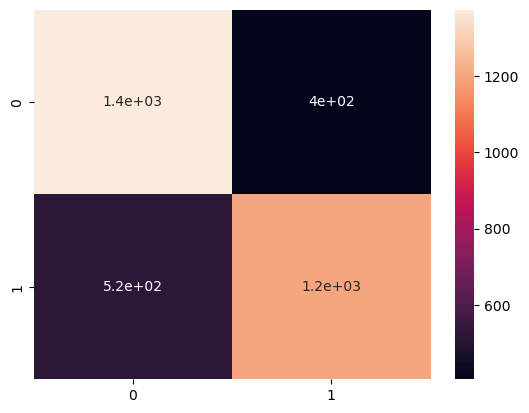

In [ ]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_values)
plt.figure()
sns.heatmap(cm, annot=True)

In [ ]:
# Delete the end-point

Xgboost_classifier.delete_endpoint()

[02/05/25 22:58:35] INFO     Deleting endpoint configuration with name: xgboost-classifier          ]8;id=748400;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=305094;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4865\4865]8;;\

                    INFO     Deleting endpoint with name: xgboost-classifier                        ]8;id=768443;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=347791;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\